In [1]:
import pandas as pd
import os
import os.path as op
from tms_risk.utils import get_tms_subjects, get_tms_conditions
from tqdm.contrib.itertools import product
import numpy as np
import matplotlib.pyplot as plt
import shutil

bids_folder = '/data/ds-tmsrisk'


def get_fisher_information(subject, session, smoothed, n_voxels=0, bids_folder=bids_folder):

    subject, session = int(subject), int(session)

    key = 'fisher_information.denoise'

    if smoothed:
        key += '.smoothed'

    return pd.read_csv(op.join(bids_folder, 'derivatives', key, f'sub-{subject:02d}', f'ses-{session}', 'func', f'sub-{subject:02d}_ses-{session}_nvoxels-{n_voxels}_fisher_information.tsv'), sep='\t')

In [5]:
subjects = get_tms_subjects(bids_folder)
sessions = [2,3]
smoothed = [True, False]
n_voxels = [1]

tms_dict = get_tms_conditions()

df = []
keys = []

for subject, session, smooth, nv in product(subjects, sessions, smoothed, n_voxels):
    
    try:
        df.append(get_fisher_information(subject, session, smoothed=smooth, n_voxels=nv))

        keys.append((subject, session, smooth, tms_dict[f'{subject:02d}'][session]))
    except FileNotFoundError as e:
        pass

df = pd.concat(df, keys=keys, names=['subject', 'session', 'smoothed', 'stimulation_condition'])

df['log(fi)'] = np.log(df['Fisher information'])

  0%|          | 0/140 [00:00<?, ?it/s]

In [6]:
df['log(fi)'] = np.log(df['Fisher information'])

/Users/gdehol/mambaforge/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


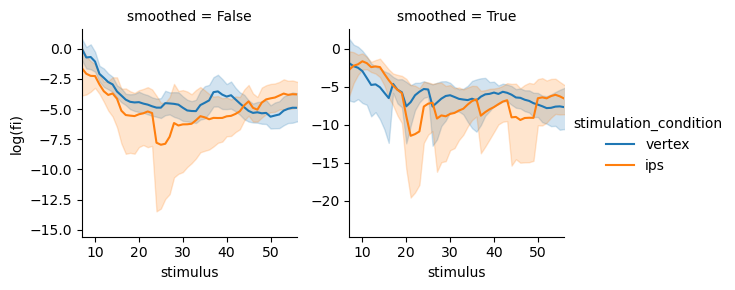

In [7]:
import seaborn as sns


g = sns.FacetGrid(df.reset_index(), col='smoothed', hue='stimulation_condition', sharey=False)

g.map(sns.lineplot, 'stimulus', 'log(fi)', estimator='mean')

g.add_legend()

g.set(xlim=(7, 56))


In [8]:
import bambi as bmb

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [9]:
df['log_fi'] = df['log(fi)']

In [10]:
df[np.isfinite(df['log_fi'])].shape, df.shape

((13607, 4), (13965, 4))

In [11]:
tmp = df.xs(False, 0, 'smoothed').reset_index()
tmp = tmp[np.isfinite(tmp['log_fi'])]

model = bmb.Model('log_fi ~ bs(stimulus, df=5)*stimulation_condition + (bs(stimulus, df=5)*stimulation_condition|subject)', tmp)

In [13]:
idata = model.fit(cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [log_fi_sigma, Intercept, bs(stimulus, df=5), stimulation_condition, bs(stimulus, df=5):stimulation_condition, 1|subject_sigma, 1|subject_offset, bs(stimulus, df=5)|subject_sigma, bs(stimulus, df=5)|subject_offset, stimulation_condition|subject_sigma, stimulation_condition|subject_offset, bs(stimulus, df=5):stimulation_condition|subject_sigma, bs(stimulus, df=5):stimulation_condition|subject_offset]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3536 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [52]:
to_predict = pd.MultiIndex.from_product([np.arange(7., 101.), ['ips', 'vertex']], names=['stimulus', 'stimulation_condition']).to_frame(index=False)


prediction = model.predict(idata, data=to_predict, include_group_specific=False, kind='pps', inplace=False)

In [53]:
import arviz as az

def get_hdi(d):
    return az.hdi(d.values, hdi_prob=0.67)

<Axes: xlabel='stimulus', ylabel='log_fi'>

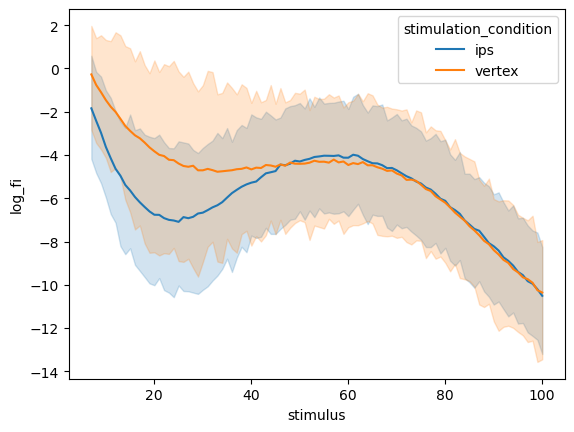

In [54]:
prediction = prediction.posterior_predictive.to_dataframe().unstack([0, 1])
prediction.index = pd.MultiIndex.from_frame(to_predict)
prediction = prediction.stack([1,2])

sns.lineplot(x='stimulus', y='log_fi', hue='stimulation_condition', data=prediction.reset_index(), errorbar=get_hdi)

<Axes: xlabel='stimulus', ylabel='diff'>

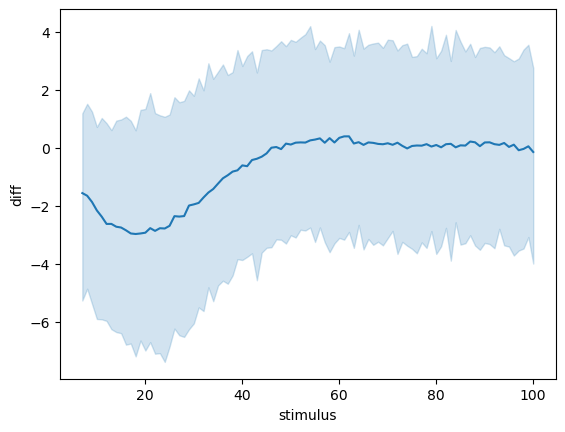

In [55]:
diff = prediction.unstack(['stimulation_condition']).droplevel(0, 1)

diff = (diff['ips'] - diff['vertex']).to_frame('diff')
sns.lineplot(x='stimulus', y='diff', data=diff.reset_index(), errorbar=get_hdi) 

In [56]:
tmp = df.xs(False, 0, 'smoothed').reset_index()
tmp = tmp[np.isfinite(tmp['log_fi'])]

model = bmb.Model('log_fi ~ bs(stimulus, df=5)*stimulation_condition + (1|subject)', tmp)

In [57]:
idata = model.fit(cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_fi_sigma, Intercept, bs(stimulus, df=5), stimulation_condition, bs(stimulus, df=5):stimulation_condition, 1|subject_sigma, 1|subject_offset]


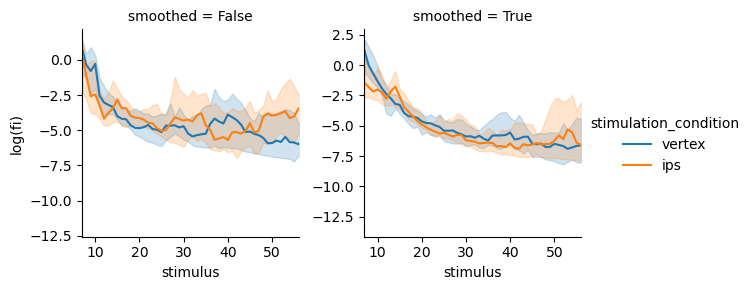

In [9]:
import seaborn as sns


g = sns.FacetGrid(df.reset_index(), col='smoothed', hue='stimulation_condition', sharey=False)

g.map(sns.lineplot, 'stimulus', 'log(fi)', estimator='median')

g.add_legend()

g.set(xlim=(7, 56))


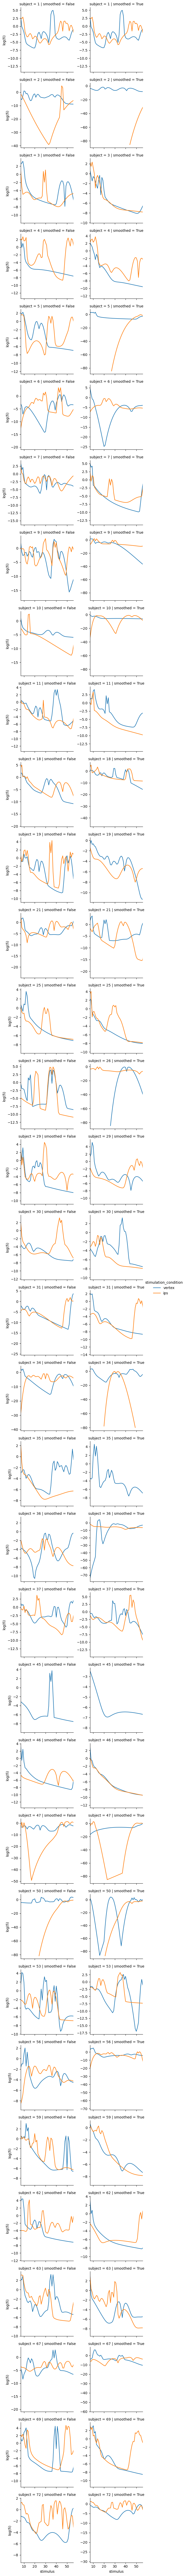

In [10]:
import seaborn as sns


g = sns.FacetGrid(df.reset_index(), col='smoothed', row='subject', hue='stimulation_condition', sharey=False)

g.map(sns.lineplot, 'stimulus', 'log(fi)', estimator='mean')

g.add_legend()

g.set(xlim=(7, 56))
